# Graph learning
This notebook is about graph learning based on the paper "Learning Heat Diffusion Graphs" written by *Dorina Thanou, Xiaowen Dong, Daniel Kressner*, and *Pascal Frossard*

### Prerequisites

In [1]:
# import numpy as np
import numpy as np
import pygsp as pg
# set maximum presicion of float (for nice looking)
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

# random seed
np.random.seed(7)

### A random graph

In [2]:
import networkx as nx
import learnHeat as lh
from matplotlib import pyplot as plt
import pygsp.plotting as plotting
# number of nodes
N = 20

# random grapht
plt.figure()
rg = pg.graphs.ErdosRenyi(N, p=0.4)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

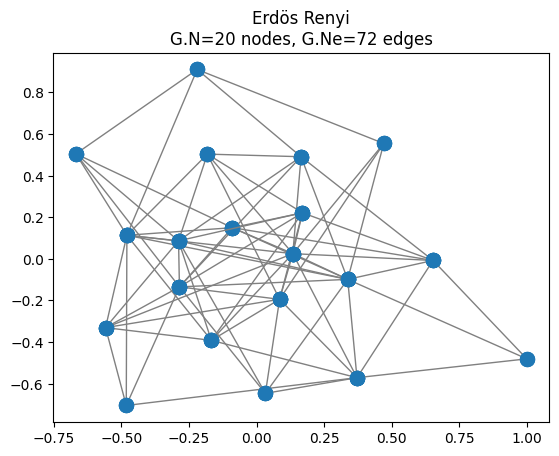

In [3]:
# figure
plt.figure()
rg.set_coordinates()
plotting.plot_graph(rg)

### Graph signal based on the topology

In [4]:
# tau (ground truth)
tau_ground = [2.5, 4]

# Dictionary based on the Laplacian and tau
L_ground = rg.L.todense()
D_ground = lh.D(L_ground, tau_ground)

# Number of observations
M = 20000

random_atoms = []
random_hs = []
for m in range(M):
    random_atoms.append(np.random.choice(D_ground.shape[1], 3, replace=False))
    random_hs.append(np.random.randn(3))

### Observations

In [5]:
# standard deviation of noise
se = 0

# generation of observations
xs = []
H_ground = np.zeros((N*len(tau_ground),M))
for m, atom in enumerate(random_atoms):
    xs.append(np.squeeze(D_ground[:,atom]@random_hs[m]))
    H_ground[atom,m] = random_hs[m]
    
# before adding noise
X_clean = np.matrix(xs).T

# noisy observations
X = X_clean + np.sqrt(se)*np.random.randn(X_clean.shape[0],X_clean.shape[1])

### Initialize parameters (dictionary, graph, and tau)

In [6]:
rg = nx.fast_gnp_random_graph(N, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*N
tau0 = [1, 2]
H0 = np.random.rand(lh.D(L0, tau0).shape[1], X.shape[1])

In [23]:
result = lh.learn_heat(X = X, 
                    L0=L0, H0 = H0, tau0=tau0, 
                    verbose=False, 
                    max_iter = 1000, alpha = 0.01, beta=0.1)

/home/aner/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Result of learning

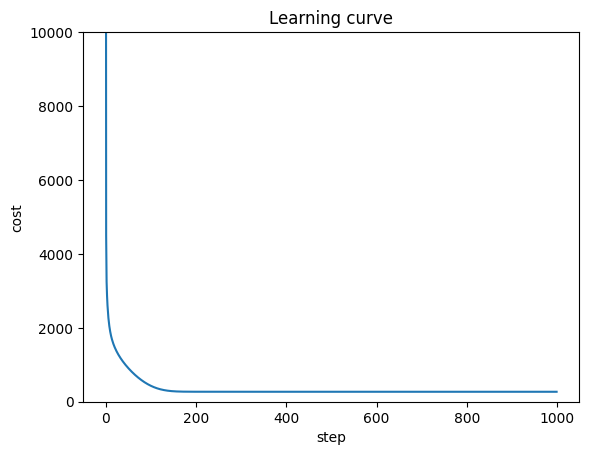

In [24]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(result["learning_curve"]["step"], result["learning_curve"]["cost"])
plt.xlabel("step")
plt.ylabel("cost")
plt.ylim([0,10000])
plt.title("Learning curve")
plt.show()

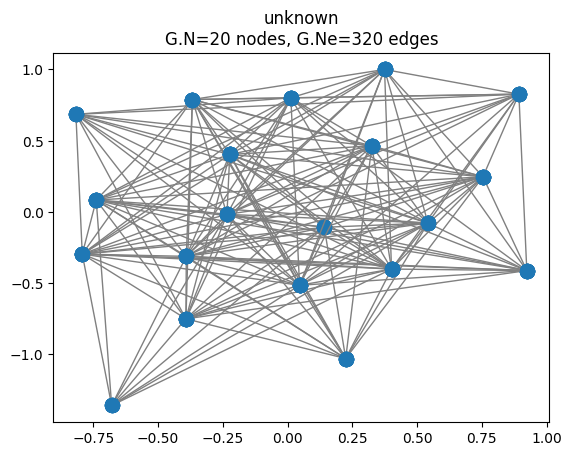

In [29]:
W = -result["L"]
np.fill_diagonal(W,0)
W[W<0.05] = 0
learned = pg.graphs.Graph(W)
learned.set_coordinates()
plotting.plot_graph(learned)

In [36]:
import scores_table as scort
vec1 = lh.laplacian_to_vec(result["L"])
print(vec1)
vec2 = lh.laplacian_to_vec(L_ground)
print(vec2)
res = scort.threshold_precision_recall(vec1,vec2,100)

[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.04968 0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.04984 0.05542 0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.05628 0.0505  0.05051
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.04928
 0.05082 0.0576  0.05149 0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.05252 0.05069 0.05018 0.05532 0.05224 0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.05231 0.05625 0.05607 0.05362 0.0521  0.05116
 0.      0.      0.      0.      

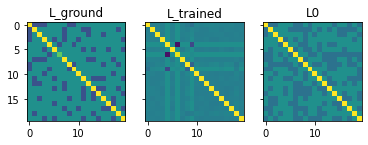

In [ ]:
vmin = -0.5
vmax = 0.5
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(L_ground/np.trace(L_ground)*N, vmin = vmin, vmax = vmax)
ax1.set_title('L_ground')
ax2.imshow(result["L"], vmin = vmin, vmax = vmax)
ax2.set_title('L_trained')
ax3.imshow(L0, vmin = vmin, vmax = vmax)
ax3.set_title('L0')
plt.show()

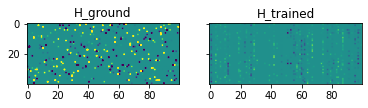

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(H_ground, vmin = vmin, vmax = vmax)
ax1.set_title('H_ground')
ax2.imshow(result["H"], vmin = vmin, vmax = vmax)
ax2.set_title('H_trained')
plt.show()